Stock Trading Bot calculater using Custom CNN model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter, MaxNLocator
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
import gradio as gr
import matplotlib.animation as animation

In [2]:
# Function to predict future stock prices using the trained model
def predict_stock_prices(symbol, initial_capital, start_date, end_date):
    global cash, stocks, buy_price, sell_price, final_capital, df, test_df, sequence_length, features, model, buy_count, sell_count

    buy_count = 0
    sell_count = 0

    # Append '.csv' to the symbol to construct the filename
    filename = f"{symbol}.csv"

    # Construct the path to the data file
    data_path = os.path.join('archive', 'stocks', filename)

    # Load the dataset
    df = pd.read_csv(data_path)

    # Ensure correct data types
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Automatically determine the start and end dates of the data
    available_start_date = df.index.min()
    available_end_date = df.index.max()

    # Ensure provided dates are within the available range
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date < available_start_date or end_date > available_end_date:
        raise ValueError(f"Date range out of bounds. Available range is from {available_start_date.date()} to {available_end_date.date()}")

    # Use the determined date range
    df = df[start_date:end_date]

    # Feature columns and target
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    target = 'Close'

    # Check if the subset is empty
    if df.empty:
        raise ValueError("DataFrame is empty. Check the date range and ensure the data file contains data for the specified period.")

    # Normalize the data
    scaler = MinMaxScaler()
    if not df[features].empty:
        df[features] = scaler.fit_transform(df[features])
    else:
        raise ValueError("DataFrame is empty or features are not selected correctly.")

    # Create sequences (e.g., using past 30 days to predict the next day)
    sequence_length = 30

    def create_sequences(data, seq_length, features, target):
        sequences = []
        labels = []
        for i in range(len(data) - seq_length):
            sequences.append(data.iloc[i:i + seq_length][features].values)
            labels.append(data.iloc[i + seq_length][target])
        return np.array(sequences), np.array(labels)

    # Split the data into training and testing sets
    train_size = int(len(df) * 0.8)
    train_df = df[:train_size]
    test_df = df[train_size:]

    # Check if the test data is too small, and adjust accordingly
    if len(test_df) <= sequence_length:
        train_df = df
        test_df = df
        sequence_length = max(1, int(len(df) * 0.2))

    # Create sequences
    X_train, y_train = create_sequences(train_df, sequence_length, features, target)
    X_test, y_test = create_sequences(test_df, sequence_length, features, target)

    # Check the shapes of the data
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Ensure the test data is not empty
    if X_test.shape[0] == 0 or y_test.shape[0] == 0:
        raise ValueError("Test data is empty. Increase the size of the dataset or adjust the sequence length.")

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, len(features))),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(20, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # Train the model
    model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

    # Reset cash and stocks
    cash = initial_capital
    stocks = 0
    buy_dates = []
    sell_dates = []
    buy_price = None
    sell_price = None

    # Initialize logs
    logs = []
    capital_changes = [f"Initial Capital: ${cash}"]

    # Generate predictions
    df['Predicted_Close'] = np.nan
    for i in range(len(test_df) - sequence_length):
        X_input = test_df.iloc[i:i + sequence_length][features].values
        X_input = X_input.reshape((1, sequence_length, len(features)))
        pred = model.predict(X_input)[0][0]
        df.iloc[train_size + sequence_length + i, df.columns.get_loc('Predicted_Close')] = pred

    # Initialize data for animation
    dates = []
    close_prices = []
    predicted_prices = []
    buys = {'dates': [], 'prices': []}
    sells = {'dates': [], 'prices': []}

    # Define the buy and sell logic
    df['Min'] = df['Low'][df['Low'] == df['Low'].rolling(window=3, center=True).min()]
    df['Max'] = df['High'][df['High'] == df['High'].rolling(window=3, center=True).max()]

    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.suptitle('Stock Prices with Buy/Sell Signals and Volume', fontsize=16)

    # Plot the closing prices and predicted closing prices
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    date_form = DateFormatter("%Y-%m")
    ax1.xaxis.set_major_formatter(date_form)



    # Add grid lines
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Plot the data with more details
    line, = ax1.plot(df.index, df['Close'], label='Close Prices', color='blue', linewidth=1) #Blue Line
    pred_line, = ax1.plot(df.index, df['Predicted_Close'], label='Predicted Close Prices', linestyle='--', color='orange', linewidth=1) #Yellow Line
    buy_scatter = ax1.scatter([], [], marker='^', color='green', label='Buy Signal', s=100)     #Buy Signal(Green)
    sell_scatter = ax1.scatter([], [], marker='v', color='red', label='Sell Signal', s=100)     #Sell Signal(Red)

    # Plot moving averages
    df['SMA9'] = df['Close'].rolling(window=9).mean()
    df['SMA21'] = df['Close'].rolling(window=21).mean()
    ax1.plot(df.index, df['SMA9'], label='SMA 9', color='purple', linewidth=1) #SMA9 Purple Line
    ax1.plot(df.index, df['SMA21'], label='SMA 21', color='cyan', linewidth=1) #SMA21 Cyan Line

    ax1.legend(loc='upper left')

    # Create a secondary y-axis for the volume bars
    ax2 = ax1.twinx()
    ax2.set_ylabel('Volume')
    ax2.bar(df.index, df['Volume'], color='blue', alpha=0.3, width=1)
    ax2.grid(False)
    ax2.set_ylim(0,5)

    # Format x-axis to show only the major ticks and labels
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=8))

    # Improve y-axis formatting for better readability
    ax1.yaxis.set_major_formatter('${x:,.2f}')

    # Function to format volume axis
    def volume_formatter(x, pos):
        if x >= 1e9:
            return f'{x*1e-9:.1f}B'
        elif x >= 1e6:
            return f'{x*1e-6:.1f}M'
        elif x >= 1e3:
            return f'{x*1e-3:.1f}K'
        else:
            return f'{x:.0f}'

    ax2.yaxis.set_major_formatter(FuncFormatter(volume_formatter))

    def animate(i):
        global cash, stocks, buy_price, sell_price, final_capital, buy_count, sell_count

        if i >= len(df):
            return

        current_date = df.index[i]
        current_low = df['Low'].iloc[i]
        current_high = df['High'].iloc[i]
        current_close = df['Close'].iloc[i]
        current_pred = df['Predicted_Close'].iloc[i]

        dates.append(current_date)
        close_prices.append(current_close)
        predicted_prices.append(current_pred)

        if not np.isnan(df['Min'].iloc[i]):
            if cash > 0:
                buy_price = current_low
                stocks = cash / buy_price
                cash = 0
                buys['dates'].append(current_date)
                buys['prices'].append(current_close)
                log = f"Bought at {buy_price:.2f} on {current_date.date()}"
                logs.append(log)
                buy_count += 1

        if not np.isnan(df['Max'].iloc[i]):
            if stocks > 0:
                sell_price = current_high
                cash = stocks * sell_price
                stocks = 0
                sells['dates'].append(current_date)
                sells['prices'].append(current_close)
                log = f"Sold at {sell_price:.2f} on {current_date.date()}"
                logs.append(log)
                sell_count += 1
                capital_changes.append(f"Capital on {current_date.date()}: ${cash:.2f}")

        final_capital = cash + stocks * current_close

        line.set_data(dates, close_prices)
        pred_line.set_data(dates, predicted_prices)
        if buys['dates']:
            buy_scatter.set_offsets(np.c_[buys['dates'], buys['prices']])
        if sells['dates']:
            sell_scatter.set_offsets(np.c_[sells['dates'], sells['prices']])
        ax1.relim()
        ax1.autoscale_view()
        ax2.relim()
        ax2.autoscale_view()

        return line, pred_line, buy_scatter, sell_scatter

    ani = animation.FuncAnimation(fig, animate, frames=len(df), interval=1000, repeat=False)  # Adjust interval for frame rate
    ani.save('trading_animation.gif', writer='pillow', fps=1)  # Adjust fps for realistic animation

    logs.append(f"Final Capital: ${final_capital:.2f}")
    capital_changes.append(f"Final Capital: ${final_capital:.2f}")
    order_summary = f"Total Buy Orders: {buy_count}\nTotal Sell Orders: {sell_count}"

    return 'trading_animation.gif', '\n'.join(logs), '\n'.join(capital_changes), order_summary

Below is the available data

In [3]:
def get_available_date_range(symbol):
    filename = f"{symbol}.csv"
    data_path = os.path.join('archive', 'stocks', filename)
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    available_start_date = df['Date'].min().date()
    available_end_date = df['Date'].max().date()
    return available_start_date, available_end_date

In [4]:
def update_date_range(symbol):
    available_start_date, available_end_date = get_available_date_range(symbol)
    return f"Available date range for {symbol}: {available_start_date} to {available_end_date}"

def main(symbol, initial_capital, start_date, end_date):
    date_range = update_date_range(symbol)
    gif, logs, capital_changes, order_summary = predict_stock_prices(symbol, initial_capital, start_date, end_date)
    return date_range, gif, logs, capital_changes, order_summary


In [5]:
# Get the list of available CSV files
available_symbols = [f.split('.')[0] for f in os.listdir('archive/stocks') if f.endswith('.csv')]

with gr.Blocks() as iface:
    symbol_input = gr.Dropdown(label="Stock Ticker Symbol", choices=available_symbols, interactive=True, allow_custom_value=True)
    date_range_output = gr.Textbox(label="Available Date Range", interactive=False)
    initial_capital_input = gr.Number(label="Initial Capital", value=10000, step=100)
    start_date_input = gr.Textbox(label="Start Date (YYYY-MM-DD)")
    end_date_input = gr.Textbox(label="End Date (YYYY-MM-DD)")
    order_summary_output = gr.Textbox(label="Order Summary", interactive=False)
    gif_output = gr.Image(type="filepath")
    logs_output = gr.Textbox(label="Logs", interactive=False)
    capital_changes_output = gr.Textbox(label="Capital Changes", interactive=False)

    symbol_input.change(
        fn=update_date_range,
        inputs=symbol_input,
        outputs=date_range_output
    )

    predict_button = gr.Button("Predict")
    predict_button.click(
        fn=main,
        inputs=[symbol_input, initial_capital_input, start_date_input, end_date_input],
        outputs=[date_range_output, gif_output, logs_output, capital_changes_output, order_summary_output]
    )

#iface.launch()

In [6]:
# Chatbot function
def stock_chatbot(message, history):
    # Simple response logic for the chatbot
    if "predict" in message.lower():
        return "You can predict stock prices using the tool above!"
    elif "zs" in message.lower():
        return "ZS is thi stock"
    else:
        return "I'm here to help with your stock queries!"

# Modify your existing gr.Blocks layout
with gr.Blocks() as iface:
    with gr.Tab("Stock Prediction"):
        symbol_input = gr.Dropdown(label="Stock Ticker Symbol", choices=available_symbols, interactive=True, allow_custom_value=True)
        date_range_output = gr.Textbox(label="Available Date Range", interactive=False)
        initial_capital_input = gr.Number(label="Initial Capital", value=10000, step=100)
        start_date_input = gr.Textbox(label="Start Date (YYYY-MM-DD)")
        end_date_input = gr.Textbox(label="End Date (YYYY-MM-DD)")
        order_summary_output = gr.Textbox(label="Order Summary", interactive=False)
        gif_output = gr.Image(type="filepath")
        logs_output = gr.Textbox(label="Logs", interactive=False)
        capital_changes_output = gr.Textbox(label="Capital Changes", interactive=False)

        symbol_input.change(
            fn=update_date_range,
            inputs=symbol_input,
            outputs=date_range_output
        )

        predict_button = gr.Button("Predict")
        predict_button.click(
            fn=main,
            inputs=[symbol_input, initial_capital_input, start_date_input, end_date_input],
            outputs=[date_range_output, gif_output, logs_output, capital_changes_output, order_summary_output]
        )
    
    with gr.Tab("Chatbot"):
        gr.ChatInterface(stock_chatbot).launch()

#iface.launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


3 Pretrained CNN models

Hugging Face 

Restnet50
Inception V3
DenseNet121


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Stock Price: $-0.12


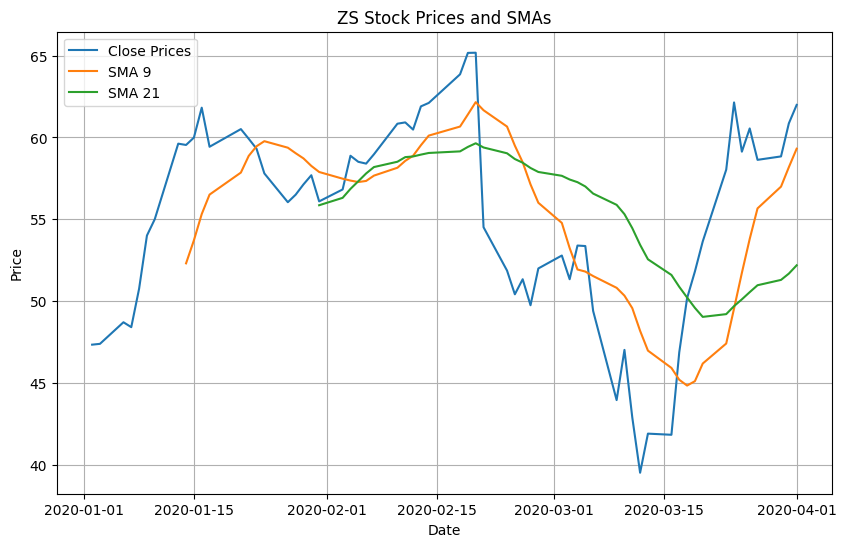

In [11]:
#Restnet50 Pretrained model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

def generate_stock_image(symbol, start_date, end_date):
    # Load your stock data
    data = pd.read_csv(f'archive/stocks/{symbol}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data[start_date:end_date]

    # Calculate Simple Moving Averages (SMA9 and SMA21)
    data['SMA9'] = data['Close'].rolling(window=9).mean()
    data['SMA21'] = data['Close'].rolling(window=21).mean()

    # Create and save the image
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Close Prices')
    plt.plot(data.index, data['SMA9'], label='SMA 9')
    plt.plot(data.index, data['SMA21'], label='SMA 21')
    plt.legend()
    plt.title(f'{symbol} Stock Prices and SMAs')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.savefig(f'{symbol}_stock_image.png')

    return f'{symbol}_stock_image.png'

# Generate the stock image for AAPL
image_path = generate_stock_image('ZS', '2020-01-01', '2020-04-01')

# Load ResNet50 base model with ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add custom layers for stock prediction
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='linear')(x)  # Linear activation for regression tasks

# Final ResNet50 model for stock prediction
resnet_model = Model(inputs=resnet_base.input, outputs=predictions)
resnet_model.compile(optimizer='adam', loss='mse')

# Load and preprocess the stock image
img_path = 'ZS_stock_image.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predict stock price
predicted_price = resnet_model.predict(x)
print(f"Predicted Stock Price: ${predicted_price[0][0]:.2f}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Stock Price: $0.93


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 21,770,401 (83.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

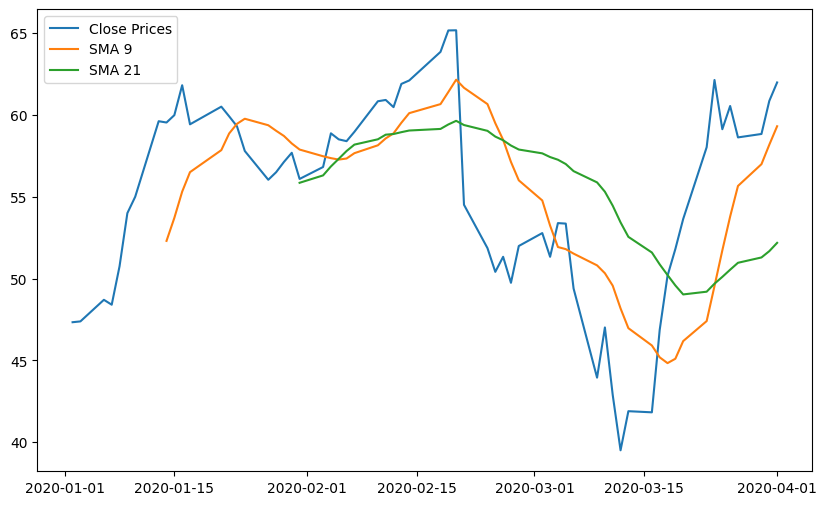

In [13]:
# Block 2: InceptionV3 Pre-trained Model Integration

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def generate_stock_image(symbol, start_date, end_date):
    # Load your stock data from the correct path
    data = pd.read_csv(f'archive/stocks/{symbol}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data[start_date:end_date]

    # Calculate SMAs
    data['SMA9'] = data['Close'].rolling(window=9).mean()
    data['SMA21'] = data['Close'].rolling(window=21).mean()

    # Create and save the image
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Close Prices')
    plt.plot(data.index, data['SMA9'], label='SMA 9')
    plt.plot(data.index, data['SMA21'], label='SMA 21')
    plt.legend()
    plt.savefig(f'{symbol}_stock_image.png')

    return f'{symbol}_stock_image.png'

# Generate the stock image for ZS
image_path = generate_stock_image('ZS', '2020-01-01', '2020-04-01')

# Load InceptionV3 base model with ImageNet weights
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add custom layers for stock prediction
x = inception_base.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='linear')(x)  # Linear activation for regression tasks

# Final InceptionV3 model for stock prediction
inception_model = Model(inputs=inception_base.input, outputs=predictions)
inception_model.compile(optimizer='adam', loss='mse')

# Load the image and prepare it for prediction
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predict stock price
predicted_price = inception_model.predict(x)
print(f"Predicted Stock Price: ${predicted_price[0][0]:.2f}")

# Summary of the model
inception_model.summary()




29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Stock Price: $-0.29


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

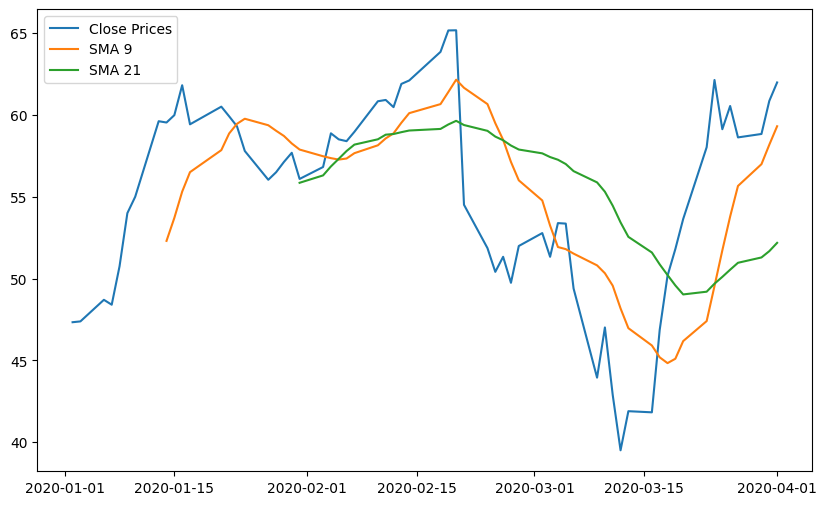

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

def generate_stock_image(symbol, start_date, end_date):
    # Load your stock data from the correct path
    data = pd.read_csv(f'archive/stocks/{symbol}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data[start_date:end_date]

    # Calculate SMAs
    data['SMA9'] = data['Close'].rolling(window=9).mean()
    data['SMA21'] = data['Close'].rolling(window=21).mean()

    # Create and save the image
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Close Prices')
    plt.plot(data.index, data['SMA9'], label='SMA 9')
    plt.plot(data.index, data['SMA21'], label='SMA 21')
    plt.legend()
    plt.savefig(f'{symbol}_stock_image.png')

    return f'{symbol}_stock_image.png'

# Generate the stock image for ZS
image_path = generate_stock_image('ZS', '2020-01-01', '2020-04-01')

# Load DenseNet121 base model with ImageNet weights
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add custom layers for stock prediction
x = densenet_base.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='linear')(x)  # Linear activation for regression tasks

# Final DenseNet121 model for stock prediction
densenet_model = Model(inputs=densenet_base.input, outputs=predictions)
densenet_model.compile(optimizer='adam', loss='mse')

# Load the image and prepare it for prediction
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predict stock price
predicted_price = densenet_model.predict(x)
print(f"Predicted Stock Price: ${predicted_price[0][0]:.2f}")

# Summary of the model
densenet_model.summary()

